In [2]:
import pandas as pd
import os 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
from torch import  nn
from torchvision import transforms ,datasets
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler



In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
TrainData=datasets.CIFAR10(root="/home/yash/CNN_Data",train=True,transform=transforms.ToTensor(),download=True)
TestData=datasets.CIFAR10(root="/home/yash/CNN_Data",train=False,transform=transforms.ToTensor(),download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
length=len(TrainData)
length

50000

In [6]:
TrainDataSet=DataLoader(TrainData,int(length/4))
TestDataSet=DataLoader(TestData,len(TestData))

In [7]:
for data in TestDataSet:
    Xtesting,Ytesting=data

Xtesting,Ytesting=Xtesting.to(device),Ytesting.to(device)

In [8]:
Xtesting[0]

tensor([[[0.6196, 0.6235, 0.6471,  ..., 0.5373, 0.4941, 0.4549],
         [0.5961, 0.5922, 0.6235,  ..., 0.5333, 0.4902, 0.4667],
         [0.5922, 0.5922, 0.6196,  ..., 0.5451, 0.5098, 0.4706],
         ...,
         [0.2667, 0.1647, 0.1216,  ..., 0.1490, 0.0510, 0.1569],
         [0.2392, 0.1922, 0.1373,  ..., 0.1020, 0.1137, 0.0784],
         [0.2118, 0.2196, 0.1765,  ..., 0.0941, 0.1333, 0.0824]],

        [[0.4392, 0.4353, 0.4549,  ..., 0.3725, 0.3569, 0.3333],
         [0.4392, 0.4314, 0.4471,  ..., 0.3725, 0.3569, 0.3451],
         [0.4314, 0.4275, 0.4353,  ..., 0.3843, 0.3725, 0.3490],
         ...,
         [0.4863, 0.3922, 0.3451,  ..., 0.3804, 0.2510, 0.3333],
         [0.4549, 0.4000, 0.3333,  ..., 0.3216, 0.3216, 0.2510],
         [0.4196, 0.4118, 0.3490,  ..., 0.3020, 0.3294, 0.2627]],

        [[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
         [0.2000, 0.1569, 0.1765,  ..., 0.1216, 0.1255, 0.1333],
         [0.1843, 0.1294, 0.1412,  ..., 0.1333, 0.1333, 0.

In [9]:
class CifarModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.Conv1=nn.Conv2d(3,6,9)
        self.Pool1=nn.AvgPool2d(2,2)
        self.Conv2=nn.Conv2d(6,16,5)
        self.Pool2=nn.AvgPool2d(2,2)
        self.flat=nn.Flatten()
        self.Linear1=nn.Linear(16*4*4,128)
        self.Linear2=nn.Linear(128,64)
        self.Linear3=nn.Linear(64,32)
        self.Linear4=nn.Linear(32,10)
        self.Relu=nn.ReLU()
        self.softmax=nn.Softmax()
        self.Sigmoid=nn.Sigmoid()
        self.drop1=nn.Dropout(p=0.1)
        self.drop2=nn.Dropout(p=0.4)


    def forward(self,Dataset):
        X=self.Relu(self.Conv1(Dataset))
        X=self.Pool1(X)
        X=self.Relu(self.Conv2(X))
        X=self.Pool2(X)
        X=self.flat(X)
        X=self.Relu(self.Linear1(X))
        X=self.drop2(self.Relu(self.Linear2(X)))
        X=self.drop1(self.Relu(self.Linear3(X)))
        X=self.Sigmoid(self.Linear4(X))
        return(X)
        

In [10]:
lr=1e-1

Model=CifarModel().to(device)
loss_fn =nn.CrossEntropyLoss()
opt=Adam(Model.parameters(),lr)
scheduler = lr_scheduler.LinearLR(opt, start_factor=0.1, end_factor=0.001, total_iters=100)
scheduler_cos = lr_scheduler.CosineAnnealingLR(opt,T_max=20,eta_min=0.0001)

In [11]:
epochs=100
epochs_count=[]
train_loss=[]
test_loss=[]



# Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y,test_size=0.2)

# Xtrain,Ytrain=Xtrain.to(device),Ytrain.to(device)
# Xtest,Ytest=Xtest.to(device),Ytest.to(device)
for epoch in range(epochs):

    for batch in TrainDataSet:
        Xtrain,Ytrain=batch   
        # Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y,test_size=0.2)

        Xtrain,Ytrain=Xtrain.to(device),Ytrain.to(device)
        # Xtest,Ytest=Xtest.to(device),Ytest.to(device)
        Model.train()

        y_pred=Model(Xtrain)
        
        loss=loss_fn(y_pred,Ytrain)
        opt.zero_grad()

        loss.backward()

        opt.step()

        Model.eval()

        with torch.inference_mode():

            test_pred=Model(Xtesting)
            Tloss= loss_fn(test_pred,Ytesting)



    print(f"epoch:{epoch} |  train loss is :- {loss.item()}")
    print(f"epoch:{epoch} |  test  loss is :- {Tloss.item()}")

    epochs_count.append((epoch))
    train_loss.append(loss.item())
    test_loss.append(Tloss.item())

    before_lr = opt.param_groups[0]["lr"]
    scheduler.step()
    after_lr = opt.param_groups[0]["lr"]
    print("Epoch %d: Adam lr %.4f -> %.4f" % (epoch, before_lr, after_lr))


epoch:0 |  train loss is :- 2.2920398712158203
epoch:0 |  test  loss is :- 2.280844211578369
Epoch 0: Adam lr 0.0100 -> 0.0099
epoch:1 |  train loss is :- 2.2417261600494385
epoch:1 |  test  loss is :- 2.2475039958953857
Epoch 1: Adam lr 0.0099 -> 0.0098
epoch:2 |  train loss is :- 2.2268383502960205
epoch:2 |  test  loss is :- 2.2069873809814453
Epoch 2: Adam lr 0.0098 -> 0.0097
epoch:3 |  train loss is :- 2.2180986404418945
epoch:3 |  test  loss is :- 2.180715799331665
Epoch 3: Adam lr 0.0097 -> 0.0096
epoch:4 |  train loss is :- 2.1842384338378906
epoch:4 |  test  loss is :- 2.147690534591675
Epoch 4: Adam lr 0.0096 -> 0.0095
epoch:5 |  train loss is :- 2.1391913890838623
epoch:5 |  test  loss is :- 2.134383201599121
Epoch 5: Adam lr 0.0095 -> 0.0094
epoch:6 |  train loss is :- 2.1297850608825684
epoch:6 |  test  loss is :- 2.1232047080993652
Epoch 6: Adam lr 0.0094 -> 0.0093
epoch:7 |  train loss is :- 2.129899024963379
epoch:7 |  test  loss is :- 2.1171560287475586
Epoch 7: Adam l

The accuracy of the model on the unknown data is:- 80.0%


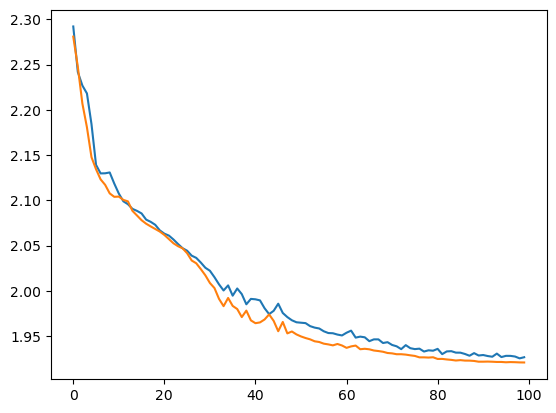

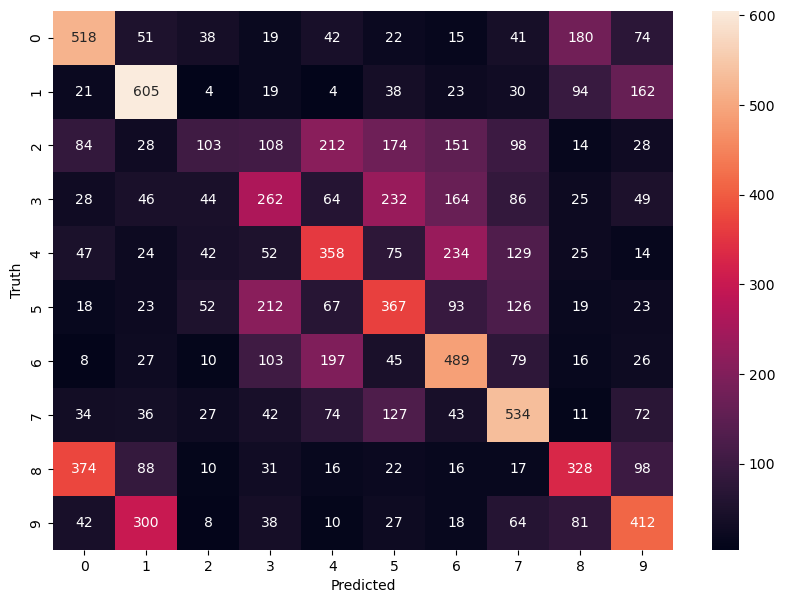

In [12]:
plt.plot(epochs_count,train_loss)
plt.plot(epochs_count,test_loss)

y_predicted =Model(Xtesting)
y_predicted=y_predicted.cpu()
y_predicted=y_predicted.detach()

ytest=(Ytesting.cpu()).detach()

y_predicted_labels=[np.argmax(i) for i in y_predicted]

cm=confusion_matrix(ytest,y_predicted_labels)
cm

plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

sum=0

for i in Ytesting:
    if(y_predicted_labels[i]==Ytesting[i]):
        sum+=1

accuracy=(sum)/len(Ytesting)

print(f"The accuracy of the model on the unknown data is:- {accuracy*100}%")
